In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from MPCProblem import MPCProblem
# from MPCProblem_new import MPCProblem # test updated MPC objective function
from util import *
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cvxpy as cp
import graphviz
import warnings
import itertools
import time
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
warnings.filterwarnings('ignore')

In [2]:
peak_flows = [310.995288, 95.952598, 140.088000, 67.040000, 77.467000, 83.829000] # kcfs
flood_pools = [750, 170, 340, 350, 170, 450] # TAF
sites = ['ORDC1', 'NBBC1', 'NDPC1', 'EXQC1', 'FRAC1', 'NMSC1']
Rmax_con = [150, 50, 9, 6, 8, 8]
RR_con = [50, 14, 9, 6, 8, 8]

baseline_TOCS = [733, 211, 558, 285, 319, 355]
perfect_TOCS = [0, 0, 449, 212, 199, 234]
hefs_TOCS = [0, 0, 481, 215, 239, 282]

In [3]:
# fcst can be baseline, perfect, hefs
fcst = 'hefs'

df_input_combine = pd.DataFrame()
for site_n in range(6):
    site = sites[site_n]
    # 1997
    df_input = pd.read_csv('output/CART_input_%s_LT_full.csv' %site, index_col = 0)
    # 2017
    # df_input = pd.read_csv('%s_CART_input_Feb2017.csv' %site, index_col = 0)
    df_input.columns = ['Rmax', 'RR', 'LT',
                        'max_above_TOCS_baseline',
                        'max_above_TOCS_perfect',
                        'max_above_TOCS_hefs']

    # add site column and covert to % peak flow and % flood pool
    df_input['site'] = site
    df_input['Rmax'] = 100*df_input['Rmax']/peak_flows[site_n]
    df_input['RR'] = 100*df_input['RR']/peak_flows[site_n]

    col_TOCS = ['max_above_TOCS_baseline','max_above_TOCS_perfect','max_above_TOCS_hefs']
    df_input[col_TOCS] = 100*df_input[col_TOCS]/flood_pools[site_n]

    df_input_combine = pd.concat([df_input_combine, df_input])

df_input_combine = df_input_combine.reset_index(drop = True)

Rmax_thres = []
RR_thres = []
LT_thres = []

df_tree_thres = pd.DataFrame()
df_acc = pd.DataFrame()
df_feat_imp = pd.DataFrame()

y_count = []

for FP in range(100, 0, -10):
    
    df_input = df_input_combine.copy()

    X = df_input[['Rmax','RR','LT']]
    y = df_input['max_above_TOCS_%s' %fcst]

    col = 'max_above_TOCS_%s' %fcst

    FP = FP

    y = y.where(df_input[col]>=FP, 0)
    y = y.where(df_input[col]<FP, 1)

    y_count.append(y.value_counts())

    class_names = ['better', 'worse']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

        
    clf = tree.DecisionTreeClassifier(max_depth = 3)
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    
    print(y_pred)
    print("Training accuracy:", metrics.accuracy_score(y_train, y_pred_train))
    print("Testing accuracy:", metrics.accuracy_score(y_test, y_pred))

    df_acc["FP%s" %FP] = [metrics.accuracy_score(y_train, y_pred_train), metrics.accuracy_score(y_test, y_pred)]

    df_tree = pd.DataFrame()
    df_tree['feature'] = clf.tree_.feature
    df_tree['threshold'] = np.round(clf.tree_.threshold, 0)
    
    df_tree_thres['FP%s' %(FP)] = df_tree[df_tree.index.isin([0,8,12])].sort_values('feature')['threshold'].values
    
    Rmax_thres.append(clf.tree_.threshold[0])
    
    # df_Rmax_thres[str(FP_per)] = Rmax_thres
    df_feat_imp['FP%s' %(FP)] = 100 * clf.feature_importances_


df_tree_thres = pd.concat([df_tree_thres, df_feat_imp, df_acc])
df_tree_thres.index = ['Rmax', 'RR', 'LT', 'Rmax_imp', 'RR_imp', 'LT_imp','train_acc', 'test_acc']

# save csv
# df_tree_thres.to_csv('df_tree_thres_%s_1997.csv' %fcst, index_col = 0)

[1. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.8929958755155606
Testing accuracy: 0.8958530183727034
[1. 0. 1. ... 1. 0. 1.]
Training accuracy: 0.8940232470941132
Testing accuracy: 0.894750656167979
[1. 1. 1. ... 1. 0. 1.]
Training accuracy: 0.893145856767904
Testing accuracy: 0.8943132108486439
[1. 1. 1. ... 1. 0. 1.]
Training accuracy: 0.8968878890138733
Testing accuracy: 0.8981627296587926
[1. 1. 1. ... 1. 0. 1.]
Training accuracy: 0.908893888263967
Testing accuracy: 0.9090113735783028
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.9241694788151481
Testing accuracy: 0.9237970253718285
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.9403149606299213
Testing accuracy: 0.9385476815398075
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.9549081364829396
Testing accuracy: 0.954488188976378
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.9627296587926509
Testing accuracy: 0.9625196850393701
[1. 1. 1. ... 1. 1. 1.]
Training accuracy: 0.9728233970753656
Testing accuracy: 0.9732808398950131


In [5]:
df_tree_thres_hefs = pd.read_csv('output/generalized_thresholds/df_tree_thres_hefs_1997.csv', index_col = 0)
df_tree_thres_perfect = pd.read_csv('output/generalized_thresholds/df_tree_thres_perfect_1997.csv', index_col = 0)

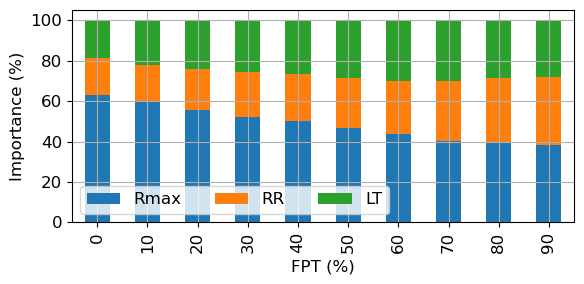

In [26]:
# feat imp for hefs
fontsize = 12
plt.rcParams.update({'font.size': fontsize})

df_feat_imp_per = df_tree_thres_hefs.loc[['Rmax_imp', 'RR_imp', 'LT_imp']]

fig, ax = plt.subplots(figsize = (6,3))
df_plot = df_feat_imp_per.transpose()
df_plot.index = range(0,100,10)
df_plot.plot.bar(ax = ax, stacked = True)
ax.legend(['Rmax', 'RR', 'LT'], loc = 3, ncol = 3, )
ax.set_xlabel('FPT (%)')
ax.set_ylabel('Importance (%)')
# ax.set_title('(b) Feature importances')
ax.grid()
plt.tight_layout()

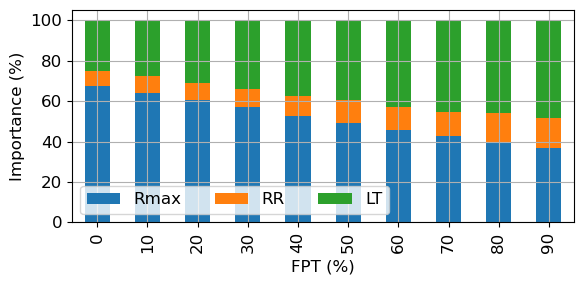

In [25]:
# feat imp for perfect
fontsize = 12
plt.rcParams.update({'font.size': fontsize})

df_feat_imp_per = df_tree_thres_perfect.loc[['Rmax_imp', 'RR_imp', 'LT_imp']]

fig, ax = plt.subplots(figsize = (6,3))
df_plot = df_feat_imp_per.transpose()
df_plot.index = range(0,100,10)
df_plot.plot.bar(ax = ax, stacked = True)
ax.legend(['Rmax', 'RR', 'LT'], loc = 3, ncol = 3, )
ax.set_xlabel('FPT (%)')
ax.set_ylabel('Importance (%)')
# ax.set_title('(b) Feature importances')
ax.grid()
plt.tight_layout()

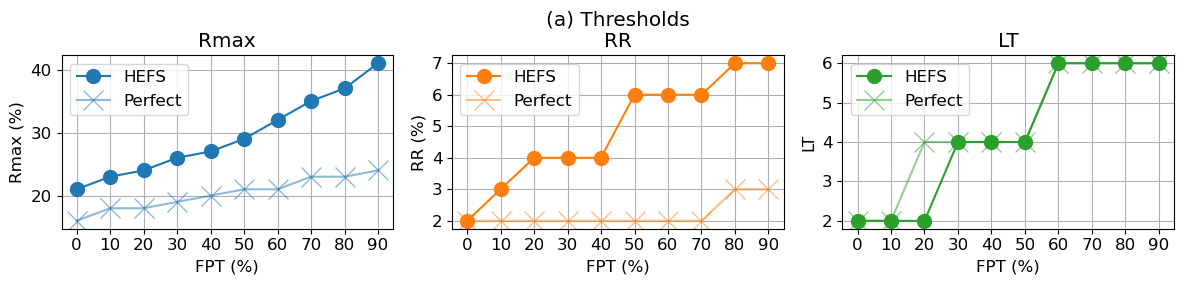

In [27]:
# generalized thresholds

fontsize = 12
plt.rcParams.update({'font.size': fontsize})
fig, ax = plt.subplots(1,3, figsize = (12,3), sharex = True)
for n,feature in enumerate(['Rmax', 'RR', 'LT']):
    axe = ax.flat[n]
    df_tree_thres_hefs.loc[feature].plot(marker = "o", markersize = 10,
                                    ax = axe, color = sns.color_palette()[n], alpha = 1.0)

    df_tree_thres_perfect.loc[feature].plot(marker = "x", markersize = 15,
                                    ax = axe, color = sns.color_palette()[n], alpha = 0.5)

    axe.set_xticks(range(10))
    axe.set_xticklabels(range(0,100,10))
    axe.set_xlabel('FPT (%)')
    axe.grid()


    axe.legend(['HEFS', 'Perfect'])
    
    if n != 2:
        axe.set_ylabel(feature +  " (%)")
    else:
        axe.set_ylabel(feature)

    if n == 1:
        axe.set_yticks([2,3,4,5,6,7])

    if n == 1:
        axe.set_title('(a) Thresholds\nRR')
    else:
        axe.set_title(feature)

plt.tight_layout()

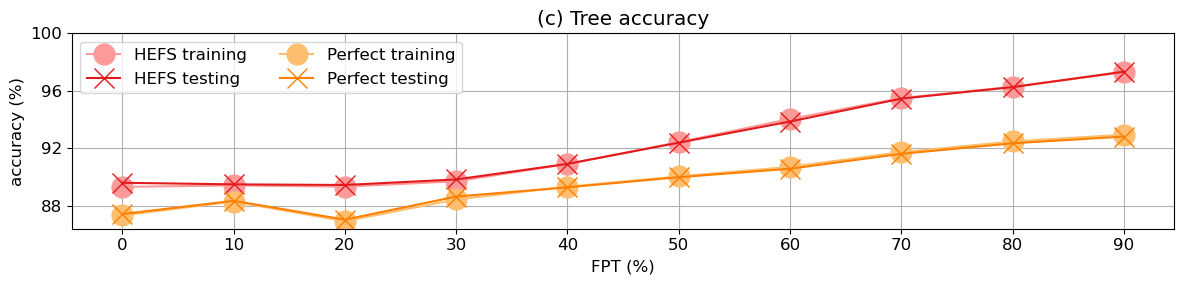

In [29]:
# accuracy

fig, ax = plt.subplots(figsize = (12,3))
df_plot = 100*df_tree_thres.loc[['train_acc', 'test_acc']].transpose()
df_plot.index = range(0,100,10)
df_plot['train_acc'].plot(marker = "o", ax = ax, markersize = 15, color = sns.color_palette('Paired')[4:5])
df_plot['test_acc'].plot(marker = "x", ax = ax, markersize = 15, color = sns.color_palette('Paired')[5:6])

df_plot_perfect = 100*df_tree_thres_perfect.loc[['train_acc', 'test_acc']].transpose()
df_plot_perfect.index = range(0,100,10)
df_plot_perfect['train_acc'].plot(marker = "o", ax = ax, markersize = 15, color = sns.color_palette('Paired')[6:7])
df_plot_perfect['test_acc'].plot(marker = "x", ax = ax, markersize = 15, color = sns.color_palette('Paired')[7:8])

ax.set_xticks(range(0,100,10))
ax.set_xticklabels(range(0,100,10))
ax.set_xlabel('FPT (%)')
ax.set_ylabel('accuracy (%)')
ax.set_yticks([88, 92, 96, 100])
ax.grid()
ax.set_title('(c) Tree accuracy')
ax.legend(['HEFS training', 'HEFS testing', 'Perfect training', 'Perfect testing'], ncol = 2)
plt.tight_layout()